---
# makemore Part 2: MLP
---

An implementation of [makemore library](https://github.com/karpathy/makemore) by Mr. Karpathy as taught in his [video](https://youtu.be/TCH_1BHY58I). makemore is a model that makes more of things that you give it. It is a character level language model, meaning that it treats example words as sequences of individual characters.


In our first approach to language modeling we used a bigram character-level model. We started off with a counting approach in which we recorded the frequency of bigrams present in the training data in a table. There are a total of $26$ letters in the English alphabet, and we include a special token used to designate the beginning and ending of a word. This gives us a table of shape $27 \times 27$. 
The first row of the table consists of the counts for all the starting characters. The columns of the table give the first character in the bigram, and the rows give the second character. 

After normalizing the rows, we were able to sample from the model by first drawing a character from the first row (corresponding to the special character  (start of sequence)). Then we would get the row corresponding to the second character distribution given the first character. From this row, we would draw the second character in the bigram, which would then become the first character in the next bigram. This process would continue until the special token was selected.

This approach is alright, but it does not scale well. For example, if we simply want to consider single-character $1$-grams, then we would have a probability distrubtion over $27$ tokens. For a bigram, we considered a table of $27 \times 27$ two-letter sequences. For a trigram, we would need to store counts in a $27 \times 27 \times 27$ array. Thus, the number of sequences we would need to store for an n-gram scales as $27^n$.


The second gradient-based approach is much more scalable. We created a single-layer neural network with $27$ fully connected neurons with a collective softmax activation (cool graphic that I made using [this website](http://alexlenail.me/NN-SVG/index.html)).
The input to the network was a $27$-dimensional one-hot-encoded vector that represents the first character in a bigram sequence. The output was a $27$-dimensional vector that represents the probability distribution of the next character in the sequence. It turned out that our weight matrix, `W`, which represents the connections between inputs and neurons, eventually converged to the bigram frequency table with training (actually, log counts). This helped build up our intuition about what the matrix multiplication between the input vector and weight matrix was doing. 

> Because the input vector is one-hot-encoded at a particular index $i$, `logits = xenc @ W` leads to the extraction of the $i$ th row of `W`. As `W` is the bigram count table, the extracted row gives the frequencies of successive characters to the input charcter. When normalized, it is our probability distribution.

<div style="display: flex;">
    <img src="img/bigram_count_table.png" alt="bigram count table" width="900" style="margin-right: -300px;">
    <img src="img/horizontal_nn.svg" alt="neural net" width="1200">
</div>



---
## 1) Basic idea of an MLP language model


The MLP model that we are building is based on the word-level language model in [this paper](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf). In their approach, they consider a large vocabulary of thousands of words that serve a similar purpose to the 27 characters in our character-level model. For our model, we could get away with one-hot-encoding each input character because we only had a total of 27, meaning that our feature space consisted of 27 dimensions. However, because one-hot-encoding produces vectors of the size of the number of possible tokens, this encoding is expensive for large numbers of tokens. Thus, the authors of the paper choose to use a neural network to learn lower-dimensional embedding vectors for each word (tens of features instead of thousands). They then use an approach for modeling that is very similar to what we have done: train a model to predict the next word given a sequence of words, optimized by maximizing the log-likelihood of the training data.

The process of embedding is a technique that aims to reduce the dimensionality of a particular feature space while retaining information about the distribution of points within it. In the paper, the embeddings of each word are randomly initialized in the lower-dimensional space and are tuned through backpropagation. During training, these vectors move throughout the space. Words with similar semantic and/or syntactic meanings should end up near each other. Words with different semantic meanings should end up in different places. 

The clustering of similar words in the embedding space helps to generalize the model to deal with out-of-distribution inputs during test time. So when an input phrase that the model did not see during training appears, it should be able to predict the next word based on the proximity of the input sequence of words to known words in the embedding space. For example, the embeddings might have been tuned to learn that the words "a" and "the" have similar meanings and are often used interchangeably, or that "dogs" and "cats" are both animals.

Suppose the model was trained on the phrase "A dog was running in a room", and is then prompted to predict the next word in the sequence "The cat is running in a", which is not explicitly in the training data. Because the two phrases are similar enough, it should be able to come up with a reasonable word to complete the sentence. So we can transfer knowledge through word proximity in the embedding space in order to generalize to novel scenarios.

The paper uses the neural network pictured below. In this particular example, the network uses a three-word (well, technically n) context to figure out the fourth word in the sequence. The words are fed into the neural network by their integer-valued index. Each of the roughly 17,000 possible words is given an index, 0 to 16,999. This index is used to pull a lower-dimensional representation of the word from a look-up table. Let's say that we want features with 30 dimensions, then the look-up table would be a $17,000 \times 30$ matrix. If we stuck to one-hot-encodings, then we would be dealing with a $17,000 \times 17,000$ matrix (all encodings stacked on top of each other). So this look-up table stores the embedding vectors for all words in the vocabulary, and because it is connected to the rest of the net, it learns these embeddings through backpropagation. Getting back to the example, if we pull 3 30-dimensional vectors (3-word context length), then our input layer has a total of 90 neurons. The hidden layer in the middle has a variable number of neurons (a hyperparameter) that are fully connected to the input layer, and it has a tanh activation function. The output layer has 17,000 neurons with a collective softmax activation to create a probability distribution over the 17,000 possible words (logits -- before exponentiation + normalization). This is the most computationally expensive layer because it is fully connected to the hidden layer. If the hidden layer has $n$ neurons, then there are a total of $17,000 \times n$ parameters stored in the weight matrix. The weight matrix between the inputs and hidden layer is shape $n \times 90$. The final output is an index drawn from the probability distribution.


<img src="img/bengio_nn.png" alt="neural net" width="400">


---
## 2) Rebuilding the training set

First, we need to create our training set of names.

---

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read the words
import os
data_path = os.path.join("data", "names.txt")
with open (data_path, "r") as f:
    words = f.read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
print("data points:", len(words))
print("longest word:", max(len(w) for w in words))
print("shortest word:", min(len(w) for w in words))
print("first 10 names:", words[:10])

data points: 32033
longest word: 15
shortest word: 2
first 10 names: ['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']


In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set("".join(words))))   # sort all of the unique chars in the list of words
stoi = {s:i+1 for i,s in enumerate(chars)}  # map char to ints, add an index for a special token
stoi["."] = 0                               # insert special token to represent start and end of words
itos = {i:s for s,i in stoi.items()}        # map int index to char

In [5]:
print("stoi:", stoi)
print("itos:", itos)

stoi: {'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
itos: {1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [6]:
# context length: how many characters do we take to predict the next one?
block_size = 3

# X is nn input, Y is target label
X, Y = [], []

num_to_print = 2
for i, w in enumerate(words):
    if i < num_to_print:
        print(f"word {i+1}: {w}")
    
    # for each word, start with the 0 index, which maps
    # to the special token to indicate the start
    # we need at least block_size many to begin to predict the (padded context)
    # first letter, this will ultimately be a rolling window of context of
    # length block_size that stores the int encoding of each token
    # in the word e.g., block_size = 3: 
    # "context ---> true_output": "... ---> e", "..e ---> m", ".em ---> m", ...
    context = [0] * block_size

    # iterate over chars in words with the special
    # token appended to the end 
    for ch in w + ".":
        idx = stoi[ch]     # get the index of the current character
        X.append(context)  # add the context, the input to the network
        Y.append(idx)      # add the true output given the context

        # for each int in the context, map it to char and print the true output
        if i < num_to_print:
            print("".join(itos[i] for i in context), "--->", itos[idx])

        # move the context window over by one
        # context[1:] gives the list of all but the first element
        # and + [idx] appends idx, the next char encoding, to the context
        context = context[1:] + [idx] # crop and append
    
# convert python lists to torch tensors
X = torch.tensor(X)
Y = torch.tensor(Y)

word 1: emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
word 2: olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .


The training set `X` is a $N \times D$ matrix, and the corresponding vector of labels `Y` has $N$ elements.  $N$ is the number of samples, and $D$ is the number of features. In our case, $D$ is equal to the `block_size` -- the context length for predicting the next character. $N$ is a little more tricky to figure out, but we just need to remember what our goal is. We want to predict the next character given a sequence of previous characters, so our labels should simply be the integer-encoded characters in the training set (plus the special ending token). Thus, $N$ is equal to the total number of letters in the training set plus the number of words (each word has one ending token).

In [7]:
print("X.shape:", X.shape)
print("X.dtype:", X.dtype)

# the first 4 rows / context windows (the word)
# you can see how they slide over by one at each successive row
print(X[:4])
print("Y.shape:", Y.shape)
print("Y.dtype:", Y.dtype)

# the first 4 true outputs for the contexts above
print(Y[:4])

X.shape: torch.Size([228146, 3])
X.dtype: torch.int64
tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        [ 5, 13, 13]])
Y.shape: torch.Size([228146])
Y.dtype: torch.int64
tensor([ 5, 13, 13,  1])


---
## 3) Implementing the embedding lookup table / input layer

In the paper, they reduced the dimensionality from 17,000 to 30. We only have 27 characters, so we will try an embedding with two dimensions to start with. 


---

We start by initializing a random array `C` of shape $(V, d)$ with $27$ rows representing each possible character (vocabulary, $V$) and $2$ columns representing each feature $d$. To get the embedding vector for the character with integer index $i$, we can simply index the lookup table `C[i]`. We can convert this indexing operation into matrix multiplication by one-hot-encoding the character with index $i$ using `F.one_hot(torch.tensor(i), num_classes=27).float()`, where we cast from a long to a float. Then `F.one_hot(torch.tensor(i), num_classes=27).float() @ C ` has shape $(1 \times 27) \ @ \ (27 \times 2) = (1 \times 2)$ (the one-hot-encoded vector is broadcasted from 27 to 1x27). The one-hot-encoded vector multiplies each column of `C`. Because most of the vector's entries are equal to zero, only the $i \text{th}$ row of `C` is extracted. For a more in-depth explanation, see section 12.1 of [Part 1](part_1_bigrams.ipynb). 

So we can think of this embedding as an integer indexing into a lookup table, or as being the first layer of a neural network. This layer has no non-linear activation functions, and has a weight matrix given by `C`. For our purposes, it is slower to one-hot-encode the integer first, so we will take the indexing approach.

In [8]:
# create a lookup table
C = torch.randn((27, 2))

In [9]:
# get the embedding vector for index 5
C[5]

tensor([0.5973, 0.5854])

In [10]:
print(F.one_hot(torch.tensor(5), num_classes=27))
print(F.one_hot(torch.tensor(5), num_classes=27).shape)
print(F.one_hot(torch.tensor(5), num_classes=27).dtype)

tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0])
torch.Size([27])
torch.int64


In [11]:
# convert the indexing operation to matrix multiplication
F.one_hot(torch.tensor(5), num_classes=27).float() @ C

tensor([0.5973, 0.5854])

We can index multiple values within a `torch.tensor` at once using different types of containers (list and tensor shown).

In [12]:
C[[5, 6, 7, 7]]

tensor([[ 0.5973,  0.5854],
        [-0.4752,  0.6409],
        [-0.0839, -1.0058],
        [-0.0839, -1.0058]])

In [13]:
C[torch.tensor([5, 6, 7, 7])]

tensor([[ 0.5973,  0.5854],
        [-0.4752,  0.6409],
        [-0.0839, -1.0058],
        [-0.0839, -1.0058]])

We can also perform multi-dimensional indexing. `X` has two dimensions, `X.shape: torch.Size([N, d])`. `C[X]` retrieves a two-dimensional embedding vector for each of the $N \times d$ vectors in `X`, `C[X].shape: torch.Size([N, d, 2])`.

In [14]:
C[X].shape

torch.Size([228146, 3, 2])

In [15]:
print(X[13])        # row 13, the context
print(X[13, 2])     # encoding of char at position j=2 in context i=13
enc = X[13, 2]
print(enc.dtype)
print(C[X][13, 2])  # embedding of X, then select embedding of char at pos j=2 in context i=13
print(C[enc])       # we can use the encoding to index directly into the embedding matrix

tensor([0, 0, 1])
tensor(1)
torch.int64
tensor([-1.8353,  0.3108])
tensor([-1.8353,  0.3108])


Each encoded character is stored as a torch int in `X`. Each character has a corresponding vector embedding. Then we need to convert all $N \times d$ characters in `X` to their corresponding embedding.

We can use indexing to get each 2-dimensional vector for $N \times d$ elements all at once (think of it as replacing each int in `X` with a 2d tuple). 

In [16]:
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

So now our embedding matrix `emb` contains the embeddings for each of the $N$ training samples. For example, `emb[0]` will have a shape $(3, 2)$ and gives us the 2-dimensional embeddings for each of the $3$ chars in the context window.

In [17]:
emb[0].shape

torch.Size([3, 2])

---
## 4) Implementing the hidden layer

---

Right now we want to pass three 2-dimensional vectors into the hidden layer at a time to ultimately predict the next character (block_size=3, embedding space dim = 2). So the total number of neurons in the input layer is $3 \times 2 = 6$. The number of neurons in the hidden layer is a hyperparameter, but we will choose $100$. So if our input `emb` has shape $(6,)$, then the weight matrix going into the first hidden layer `W1` must have shape $(6, 100)$.



In [18]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

Next, we would want to multiply the input embeddings by the weights, i.e., `emb @ W1 + b1`. However, the `emb` are stacked up in the dimensions of the input tensor, specifically `torch.Size([N, 3, 2]) = (num_examples, block_size, embedding_size)`. This means that the matrix multiplication is invalid: `emb @ W1 = (N, 3, 2) @ (6, 100)`.

We can use the [torch.cat](https://pytorch.org/docs/stable/generated/torch.cat.html) function

First let's take a look at this. Below, `emb[:, i, :]` takes all of the $N$ examples / contexts (the first : ), chooses the $i$ th char within that context, and then selects all of the embedding dimensions (second : ). Altogether, this means that we are selecting the embeddings for each of the chars in the $N$ contexts.

In [19]:
print(emb[:, 0, :].shape)  # the N 2d embeddings of the first chars in each context
print(emb[:, 1, :].shape)  # the N 2d embeddings of the second chars in each context
print(emb[:, 2, :].shape)  # the N 2d embeddings of the third chars in each context

torch.Size([228146, 2])
torch.Size([228146, 2])
torch.Size([228146, 2])


Remember, the goal is to pass the embedded context window into the network to get its prediction for the next character.

<img src="img/bengio_nn.png" alt="neural net" width="400">

Here's where we are in the picture so far:

- we have chosen a block size / context window of 3 chars, represented by the 3 green squares $w_{t-3}$, $w_{t-2}$, $w_{t-1}$
- we have embedded those 3 chars into 2-dimensional vectors with matrix `C` 
    - so in the pic above, imagine each $C(w_{t-3})$, $C(w_{t-2})$, $C(w_{t-1})$ has 2 red dots inside
- each `emb[:, i, :].shape` represents $C(w_{t-(i+1)})$ for all samples $N$, hence the shape $(N, 2)$

We now want to concatenate all these `emb[:, i, :].shape` together to create a single vector to pass into the hidden layer. But because we are working with the entire dataset / all samples, and have shapes $(N, 2)$, we will really create a tensor. This tensor will have shape $(N, 2 \times 3) = (N, 6)$ because each of the $3$ chars in the context has an embedding dimension of $2$. Thus, each row of the tensor gives us the embedding $\left[C(w_{t-3}), \ C(w_{t-2}), \ C(w_{t-1})\right]$ --> $\left[(a, b) \ (c, d) \ (e, f)\right]$ -> $\left[(a, b, c, d, e, f)\right]$, where each letter is some float. 


In practice, we need to concat along dimension 1 of `[emb[:, i, :]` with shape $(N, 2)$, meaning along the $2$ (the embedding dimension). This way, we align the embeddings of each context char `[emb[:, 0, :]`,  `[emb[:, 1, :]`,  `[emb[:, 2, :]` into the desired size of $2 + 2 + 2 = 6$.

In [20]:
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], dim=1).shape

torch.Size([228146, 6])

We could condense and generalize this using list comprehension with the given `block_size`.

In [21]:
torch.cat([emb[:, i, :] for i in range(block_size)], dim=1).shape

torch.Size([228146, 6])

Or we could be a bit craftier by using [torch.unbind](https://pytorch.org/docs/stable/generated/torch.unbind.html), which removes the specified tensor dimension, and then splits the tensor into a list of tensors. Our `emb` tensor had a shape of $(N, 3, 2)$. Then by using `torch.unbind` along dimension 1, it will split the tensor into a list of $3$ tensors, each with shape $(N, 2)$. Then concatenating these along dimension 1, we will have a final tensor of shape $(N, 3 \cdot 2) = (N, 6)$. 

In [22]:
# unbind returns a tuple of tensors, so we need to concatenate 
# them along the first dimension to create a single tensor
torch.cat(torch.unbind(emb, 1), dim=1).shape

torch.Size([228146, 6])

But there's still a better way! The operations above first created a list of new tensors, and then concatenated them into another new tensor. This was inefficient because it required the creation of new storage in memory!

Let's see another approach by first creating a tensor `a`.

In [23]:
a = torch.arange(6)
print(a)
print(a.shape)

tensor([0, 1, 2, 3, 4, 5])
torch.Size([6])


Under the hood, each tensor is just storing a sequence of values as a one-dimensional vector.

In [24]:
a.storage()

/var/folders/5n/vrz8k5mx6t7fr9v_wkql4zvc0000gn/T/ipykernel_50901/214256462.py:1: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  a.storage()


 0
 1
 2
 3
 4
 5
[torch.storage.TypedStorage(dtype=torch.int64, device=cpu) of size 6]

We can use [view](https://pytorch.org/docs/stable/generated/torch.Tensor.view.html) to manipulate how the one-dimensional sequence is interpreted to be used by an n-dimensional vector without changing the underlying values. This [blog](http://blog.ezyang.com/2019/05/pytorch-internals/) goes more into this. This is also a very efficient operation.

In [25]:
a.view(1, 2, 3)

tensor([[[0, 1, 2],
         [3, 4, 5]]])

Returning to `emb`, we can simply ask PyTorch to view it as an $(N, 6)$ tensor. It will flatten each of the $N$ values within `emb` from being a $(3, 2)$ tensor representing the 2-dimensional embeddings of the 3 context words within the block into a $(1, 6)$ tensor, effectively concatenating each context window as above. But by using `view`, we achieve this in a much more efficient manner.

In [26]:
emb.shape

torch.Size([228146, 3, 2])

In [27]:
emb[0]

tensor([[-0.0681, -0.9714],
        [-0.0681, -0.9714],
        [-0.0681, -0.9714]])

In [28]:
# emb.view(emb.shape[0], 6) # (N, 6)
emb.view(-1, 6)[0]            

tensor([-0.0681, -0.9714, -0.0681, -0.9714, -0.0681, -0.9714])

So getting back to our first set of hidden weights, we have

In [29]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

Then we can get our hidden layer by multiplying the embedded, concatenated context window with the first weight matrix.

But remember, we're not dealing with a single context window, we're dealing with all $N$ of them at once in parallel. So, we have a hidden layer of shape `emb @ W1 = (N, 6) @ (6, 100) = (N, 100)`, representing the $100$ pre-activations for each context window sample.


In [30]:
print(b1.shape)
print(W1.shape)

torch.Size([100])
torch.Size([6, 100])


The bias tensor `b1` has shape $(100)$. When added to `emb.view(-1, 6) @ W1` with shape $(N, 100)$, broadcasting will align `b1`'s dimension on the right

(N, 100) <- emb @ W1

(-, 100) <- b1

then create a dummy dimension on the left

(N, 100) <- emb @ W1

(1, 100) <- b1

making `b1` a row vector. Next, it will add the `b1` row to each of the $N$ rows in `emb @ W1`. This is what we want, since each row in `emb @ W1` represents the pre-activation of a single context window sample. So we have `emb @ W1 + b1` for each sample all done in parallel :)

In [31]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
h.shape

torch.Size([228146, 100])

---
## 5) Implementing the output layer

---

Now we need to create the weights going into the output layer. Because the hidden layer has $100$ neurons and we expect an output of $27$ possible characters, we know that `W2` must have the shape $(100, 27)$. The bias is added to the pre-activations of the output layer, so `b2` must have shape $(27)$.

In [32]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

Then the logits (raw log counts before softmax) have shape `logits = h @ W2 = (N, 100) @ (100, 27) = (N, 27)`.

In [33]:
logits = h @ W2 + b2
logits.shape

torch.Size([228146, 27])

We can take the softmax by first exponentiating `logits`, giving us the `counts`. We then divide by the partition function to normalize each row of `counts`, giving us `probs`. When we sum, we use `dim=1` to sum across each row (sum along the $27$ columns in the row). This way, each row of `probs` is a probability distribution over the next possible character given the context window provided to the neural net.

In [34]:
counts = logits.exp()
probs = counts / counts.sum(dim=1, keepdim=True)
probs.shape

torch.Size([228146, 27])

The input to the neural net was `X`, a tensor of shape $(N, \text{block\_size})$, where $N$ is the total number of context windows / samples, and $\text{block\_size}$ is the size of the context window. We also had a tensor `Y` of shape $(N)$, representing the true next character for each of the $N$ samples. We can use this to find the loss, and help train the network.

To calculate the loss, we need to get the probability of predicting the true label. That is, for each input in the dataset, `i = 0, ..., N-1`, draw the correct label, `Y[i]`, and then get its predicted probability `probs[i, Y[i]]`. Recall that each row `i` of `probs` (`probs[i]`) gives the probability of each character, and `Y[i]` gives the true character for sample `i`. So `probs[i, Y[i]]` picks out the probability of drawing the correct character next for sample `i`.  
Instead of using a for loop over `i`, we can use PyTorch indexing to get the probability for each sample in parallel

Instead of doing this

```py
for i in range(N):
    probs(i, Y[i])
```
we can use

```py
probs[torch.arange(N), Y]
```

We then use these to form the negative log-likelihood loss

In [35]:
# negative log likelihood loss
N = X.shape[0]
loss = - probs[torch.arange(N), Y].log().mean()
loss

tensor(15.1015)

We can actually calculate the loss a lot more efficiently without the need to do the softmax ourselves by using [F.cross_entropy](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html). This way, we won't have to create the intermediate tensors `counts` and `probs` in memory. In addition, the backward pass will be simpler. Remember that we can backward pass through function compositions, as each tensor is connected in the computational graph. However, while some higher-level functions may be composed of multiple lower-level functions, each with their own backprop rule, said higher-level function may also have its own backprop rule implemented. If this is the case, then we can backprop directly through its rule, instead of through the rules for each of the lower-level functions, of which our NLL loss is made up of. For this reason, it's more appealing to use `F.cross_entropy` to directly calculate the `loss`, rather than first creating `counts` using `.exp()`, `probs` using division and `.sum()`, etc. It also turns out that `F.cross_entropy` is more numerically stable for large values, since exponentiating something large yields `inf` ([1, 1000].exp() --> [2.71, inf]), which cannot be used downstream.

In [36]:
torch.tensor([1, 1000])

tensor([   1, 1000])

The way PyTorch handles overflow by large positive values (negative values don't affect this) is by subtracting off the maximum value of logits. We can arbitrarily offset the logits by any positive value that we want because of the normalization. But why does this help with overflow? Let's take a look.

Suppose we have some logits
$$
\text{logits} = \vec{z}
$$

Then we can define the softmax function as
$$
\text{softmax}(z_i) = \frac{e^{z_i}}{\sum_j e^{z_j}}
$$

In particular, we care about the case when $z_i$ is very large and very small. 

-   If $z_i < 0$ and is very small, then $\exp(z_i) \approx 0$. This would give $\text{softmax}(z_i) \approx 0$ since the corresponding term would disappear from the denominator and leave a $0$ in the numerator.
-   If $z_i > 0$ and is very big, then $\exp(z_i) \approx \infty$, which would sort of break our softmax.

Suppose we have logits arranged in ascending order such that
$$
\text{logits} = \vec{z} = (z_\text{min}, ..., z_i, ... , z_\text{max})
$$

with $z_\text{max} \gg 0$ and $z_\text{max} \gg z_j$ for all other logits in $\vec{z}$. Then by subtracting $z_\text{max}$ off, we have
$$
\vec{z} - z_\text{max} = (z_\text{min} - z_\text{max}, ..., z_i - z_\text{max}, ... , 0)
$$

So at most, the greatest value we can have in the numerator of the softmax function is $\exp(0) = 1$, and the rest in the interval $[0, 1)$ because all other $z_j < 0$. Our overflow problem has been solved!


In [37]:
logits = logits - logits.max()
counts = logits.exp() 
probs = counts / counts.sum(dim=1, keepdim=True)
loss = -probs[torch.arange(N), Y].log().mean()
print(loss)

tensor(15.1015)


In [38]:
loss = F.cross_entropy(logits, Y)
loss

tensor(15.1015)

---
## 6) All Together Now

---

Let's rewrite everything thus far compactly

In [39]:
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [40]:
g = torch.Generator().manual_seed(2147483647)  # rng seed
C = torch.randn((27, 2), generator=g)          # embedding matrix
W1 = torch.randn((6, 100), generator=g)        # hidden layer weights
b1 = torch.randn(100, generator=g)             # hidden layer bias
W2 = torch.randn((100, 27), generator=g)       # output layer weights
b2 = torch.randn(27, generator=g)              # output layer bias
parameters = [C, W1, b1, W2, b2]               # collect the parameters

In [41]:
sum(p.numel() for p in parameters)

3481

First we need to ensure that PyTorch keeps track of each operation on the parameters so that we can calculate their gradients later.

In [42]:
for p in parameters:
    p.requires_grad = True

Next we can run optimization!

We can never overfit and make the loss go exactly to $0$ because of the degenerate samples at the start of each word. For $\text{block\_size} = 3$, we have cases like "...->a", "...->e", "...->j", etc., meaning that given input "...", we can never always get the correct next character prediction ().

But this is sort of slow... right now we're training on all of the data on every iteration.

In [43]:
for _ in range(10):
    # forward pass
    emb = C[X] # (N, block_size, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (N, 100)
    logits = h @ W2 + b2 # (N, 27)
    loss = F.cross_entropy(logits, Y)

    # backward pass
    for p in parameters:   
        p.grad = None   # clear the gradients 
    loss.backward()     # populate the gradients

    # parameter update
    for p in parameters:
        p.data += -0.1 * p.grad
print(loss.item())

11.051854133605957


We can speed this up using minibatches. So instead of training on all $N$ samples at a time, let's randomly select $32$ of them to use per iteration. 

So we need to first choose a subset of the samples to use. We can do this by using `torch.randint` with the desired `batch_size`. Next, instead of using samples `X` and labels `Y`, we can pick out the subsets using `X[ix]` and `Y[ix]`. 

This makes our training a looot faster at the expense of quality. That's because minibatches can only approximate the true gradient (at each iteration) given by the whole batch of data (minibatch gradient direction is not as reliable).

In [44]:
batch_size = 32
for _ in range(1000):
    # minibatch construct
    # select a random subset of the data using the indices in X: [0, N-1]
    ix = torch.randint(0, X.shape[0], (batch_size,)) 

    # forward pass
    emb = C[X[ix]] # (batch_size, block_size, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (batch_size, 100)
    logits = h @ W2 + b2 # (batch_size, 27)
    loss = F.cross_entropy(logits, Y[ix])

    # backward pass
    for p in parameters:   
        p.grad = None   # clear the gradients 
    loss.backward()     # populate the gradients

    # parameter update
    for p in parameters:
        p.data += -0.1 * p.grad
print(loss.item())

2.6723287105560303


The loss on the entire dataset is

In [45]:
emb = C[X] # (N, block_size, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (N, 100)
logits = h @ W2 + b2 # (N, 27)
loss = F.cross_entropy(logits, Y)
loss.item()

2.7034823894500732

---
## 7) Finding a good learning rate

---

We want to find a learning rate that decreases the loss at an appreciable rate without destabilizing it. One way to figure this out is to find reasonable upper and lower bounds to search between. We can move in powers of $10$ between, say $10$ and $0.0001$ over a hundred iterations or so.

What we would find for this problem is that $0.0001$ doesn't change the loss enough, so we set a lower bound of $0.001$. The loss is unstable at $10$, so we can use $1$ as an upper bound. 

Then we can create a search range of learning rates between $0.001$ and $1$

In [46]:
# 1000 numbers evenly spaced between 0.001 and 1
lrs = torch.linspace(0.001, 1, steps=1000)

But we can do better. Instead, let's use create a list of learning rate exponents over which to search. The learning rates we use will now have the form $10^x$, where $x$ comes from the list of linearly spaced exponents. 

If we have a range of exponents from $-3$ to $0$, then we will have learning rates in the range $10^{-3} = 0.001$ to $10^0 = 1$, the same as above. This time, however, the learning rates themselves step exponentially in powers of ten, while the exponents increase linearly. The learning rate interval is spaced exponentially, while the exponent interval is spaced linearly.

In [47]:
# 1000 exponents evenly spaced between -3 and 0
lre = torch.linspace(-3, 0, steps=1000)
lrs = 10**lre

Great, now we will keep track of the learning rates

In [48]:
g = torch.Generator().manual_seed(2147483647)  # rng seed
C = torch.randn((27, 2), generator=g)          # embedding matrix
W1 = torch.randn((6, 100), generator=g)        # hidden layer weights
b1 = torch.randn(100, generator=g)             # hidden layer bias
W2 = torch.randn((100, 27), generator=g)       # output layer weights
b2 = torch.randn(27, generator=g)              # output layer bias
parameters = [C, W1, b1, W2, b2]               # collect the parameters

for p in parameters:
    p.requires_grad = True

In [49]:
# keep track of the learning rate exponent and the loss at each iteration
lrei = []   
lossi = []

batch_size = 32
for i in range(1000):
    # minibatch construct
    # select a random subset of the data using the indices in X: [0, N-1]
    ix = torch.randint(0, X.shape[0], (batch_size,)) 

    # forward pass
    emb = C[X[ix]] # (batch_size, block_size, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (batch_size, 100)
    logits = h @ W2 + b2 # (batch_size, 27)
    loss = F.cross_entropy(logits, Y[ix])

    # backward pass
    for p in parameters:   
        p.grad = None   # clear the gradients 
    loss.backward()     # populate the gradients

    # parameter update
    lr = lrs[i]
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    lrei.append(lre[i])
    lossi.append(loss.item())

We can find the learning rate and its respective exponent for which the loss is the lowest.

In the loss vs learning rate plot, we see that in the beginning the loss changes very slowly with a small learning rate. As the learning rate increases, the loss falls and eventually becomes unstable. 

The learning rate exponent plot mirrors this, but in base-10 logarithmic scale relative to the learning rate plot (lre x-axis grows linearly, lr x-axis grows exponentially 10^exp).

So we see that a good learning rate exponent is around $-1$, giving a learning rate of $10^{-1} = 0.1$.

Min learning rate exponent: -0.85 and corresponding learing rate: 1.42e-01


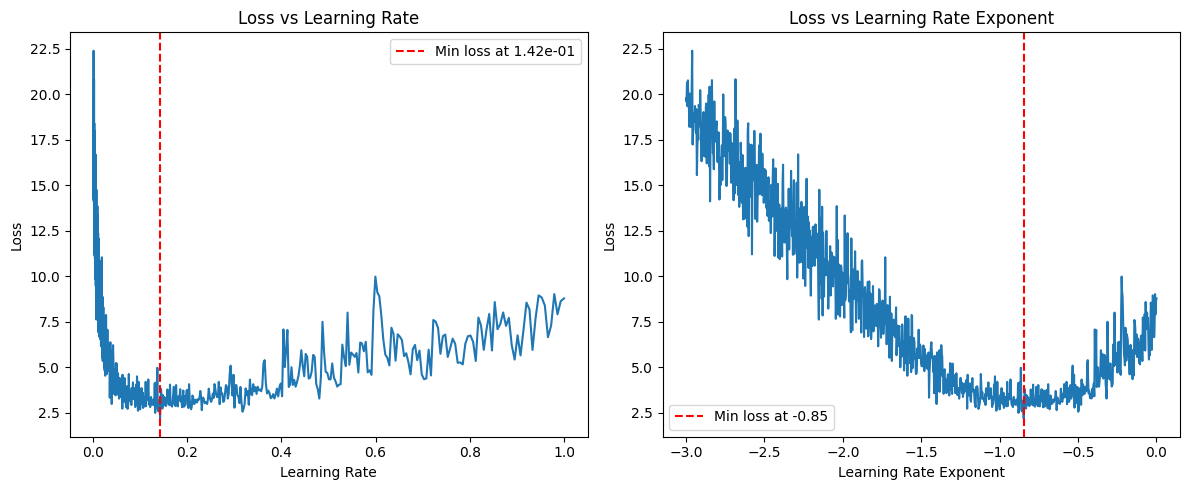

In [50]:
# find the minimum loss and the corresponding learning rate
min_loss = min(lossi)
min_loss_index = lossi.index(min_loss)
min_lrei = lrei[min_loss_index]

min_loss = min(lossi)
min_loss_index = lossi.index(min_loss)
min_lr = lrs[min_loss_index]
print(f"Min learning rate exponent: {min_lrei:.2f} and corresponding learing rate: {10**min_lrei:.2e}")


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# loss vs learning rate
ax1.plot(lrs, lossi)
ax1.axvline(x=min_lr, color="r", linestyle="--", label=f"Min loss at {min_lr:.2e}")
# ax1.set_xscale("log") # changing to log scale will reveal these plots to be the same
ax1.set_xlabel("Learning Rate")
ax1.set_ylabel("Loss")
ax1.set_title("Loss vs Learning Rate")
ax1.legend()

# loss vs learning rate exponent
ax2.plot(lrei, lossi)
ax2.axvline(x=min_lrei, color="r", linestyle="--", label=f"Min loss at {min_lrei:.2f}")
ax2.set_xlabel("Learning Rate Exponent")
ax2.set_ylabel("Loss")
ax2.set_title("Loss vs Learning Rate Exponent")
ax2.legend()



plt.tight_layout()
plt.show()


---
## 8) Train/val/test split

---

It's not enough to just lower the loss on the training data! As the capacity (~number of parameters) of a neural network grows, it becomes more able to overfit / memorize the training data. So even if the loss on the training set is low, or possible even zero, it will not be able to generalize at all outside of the material used to train it.

It is common to split up the training data into three sets:

- train (80%) - used to optimize the parameters of the model through training / gradient descent
- validation (10%) - used to optimize the hyperparameters
- test (10%) - used to evaluate the performance of the model at the end

The test set is witheld from the model during training, and is meant to serve as a proxy for unseen data it might encounter during inference. For this reason, we only want to evaluate the model on it sparingly, so as not to accidentally train on it!

First, we can take some code from above and put it into a function to build a dataset.

In [51]:
def build_dataset(words):
    block_size = 3 # context length: how many chars do we take to predict the next one
    X, Y = [], [   ]# X is nn input, Y is target label
    
    # for each word, start with the 0 index, which maps to the special token to indicate the start
    for w in words:
        context = [0] * block_size
        for ch in w + ".":      # iterate over chars in words with the special token appended to the end
            ix = stoi[ch]       # get the index of the current character
            X.append(context)   # add the context, the input to the network
            Y.append(ix)        # add the true output given the context
            # print("".join(itos[i] for i in context), "--->", itos[ix])
            context = context[1:] + [ix] # move the context window over by one
    X = torch.tensor(X) 
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

Next, we randomly shuffle the list of words

In [52]:
import random 
random.seed(42)
random.shuffle(words)

And then get the number of samples that make up 80 and 90% of the words.

In [53]:
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))
print(n1, n2)

25626 28829


And finally create our train, val, and test splits.

In [54]:
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


Now we train exclusivelt on the training set.

In [55]:
g = torch.Generator().manual_seed(2147483647)  # rng seed
C = torch.randn((27, 2), generator=g)          # embedding matrix
W1 = torch.randn((6, 100), generator=g)        # hidden layer weights
b1 = torch.randn(100, generator=g)             # hidden layer bias
W2 = torch.randn((100, 27), generator=g)       # output layer weights
b2 = torch.randn(27, generator=g)              # output layer bias
parameters = [C, W1, b1, W2, b2]               # collect the parameters

for p in parameters:
    p.requires_grad = True

sum(p.numel() for p in parameters)

3481

In [56]:
lr = 0.1
batch_size = 32
num_iters = 30_000
for i in range(num_iters):
    # minibatch construct
    # select a random subset of the data using the indices in X: [0, N-1]
    ix = torch.randint(0, Xtr.shape[0], (batch_size,)) 

    # forward pass
    emb = C[Xtr[ix]] # (batch_size, block_size, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (batch_size, 100)
    logits = h @ W2 + b2 # (batch_size, 27)
    loss = F.cross_entropy(logits, Ytr[ix])

    # backward pass
    for p in parameters:   
        p.grad = None   # clear the gradients 
    loss.backward()     # populate the gradients

    # parameter update
    for p in parameters:
        p.data += -lr * p.grad
     
    print(f"i: {i+1}/{num_iters}, loss: {loss.item()}", end="\r")

We can evaluate the performance over the entire training set

In [57]:
emb = C[Xtr] # (N, block_size, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (N, 100)
logits = h @ W2 + b2 # (N, 27)
loss = F.cross_entropy(logits, Ytr)
loss.item()

2.395537853240967

And we can evaluate using the val / dev set

In [58]:
emb = C[Xdev] # (N, block_size, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (N, 100)
logits = h @ W2 + b2 # (N, 27)
loss = F.cross_entropy(logits, Ydev)
loss.item()

2.397521495819092

We see that we get a very similar loss for both the train and dev sets. This means a couple of things:

1) We are not overfitting: the dev set is witheld during training, but gets a very similar, low loss value as the training set -- the model is not large enough to just memorize the training set (which would result in higher val loss)
2) We are underfitting: because the train / dev losses are about the same -- we can improve performance by scaling up the size of our network

Keep in mind: if the training loss is significantly lower than the val / test sets, then we are overfitting!

---
## 9) Scaling up!

---

Our current net only has $3481$ parameters in it. Above, we found that the train and val set losses are roughly the same. This means that our model is most likely underfitting, and can gain a performance boost just by scaling up the number of parameters in the network.

Instead of using $100$ hidden layer neurons, let's use $300$.

In [59]:
g = torch.Generator().manual_seed(2147483647)  # rng seed
C = torch.randn((27, 2), generator=g)          # embedding matrix
W1 = torch.randn((6, 300), generator=g)        # hidden layer weights
b1 = torch.randn(300, generator=g)             # hidden layer bias
W2 = torch.randn((300, 27), generator=g)       # output layer weights
b2 = torch.randn(27, generator=g)              # output layer bias
parameters = [C, W1, b1, W2, b2]               # collect the parameters

for p in parameters:
    p.requires_grad = True

sum(p.numel() for p in parameters)

10281

We now have a model with $10281$ parameters.

In [60]:
# keep track of the learning rate exponent and the loss at each iteration
lossi = []

lr = 0.1
batch_size = 32
num_iters = 30_000
for i in range(num_iters):
    # minibatch construct
    # select a random subset of the data using the indices in X: [0, N-1]
    ix = torch.randint(0, Xtr.shape[0], (batch_size,)) 

    # forward pass
    emb = C[Xtr[ix]] # (batch_size, block_size, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (batch_size, 300)
    logits = h @ W2 + b2 # (batch_size, 27)
    loss = F.cross_entropy(logits, Ytr[ix])

    # backward pass
    for p in parameters:   
        p.grad = None   # clear the gradients 
    loss.backward()     # populate the gradients

    # parameter update
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    lossi.append(loss.item())

    print(f"i: {i+1}/{num_iters}, loss: {loss.item()}", end="\r")

Immediately, we see that we have a higher loss than before with our smaller model. One reason for this might just be that a larger model requires more training.

Another problem might be the two-dimensional embeddings of each character. We might need to expand the dimensionality of these embeddings to allow the neural net to more effectively use the space to learn the characters.

Tracking the loss, we see it quickly falls at first, and then is very noisy. The noise comes from our use of minibatches, which approximate the true loss gradients of the full batch. By increasing the batch size, we could smooth out this plot.


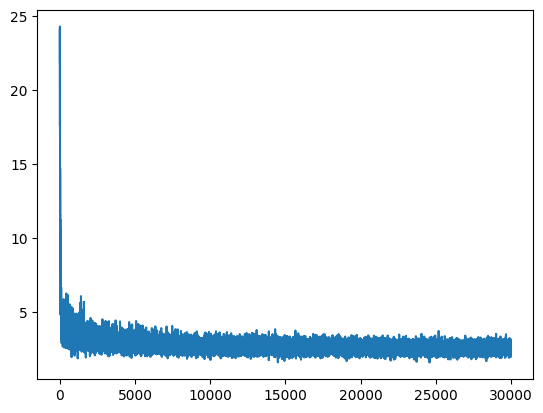

In [61]:
plt.plot(lossi)
plt.show()

---
## 10) Visualizing the embeddings

---

Because each character embedding only consists of two numbers, we can plot them!

We can see that the vowels sort of cluster together.

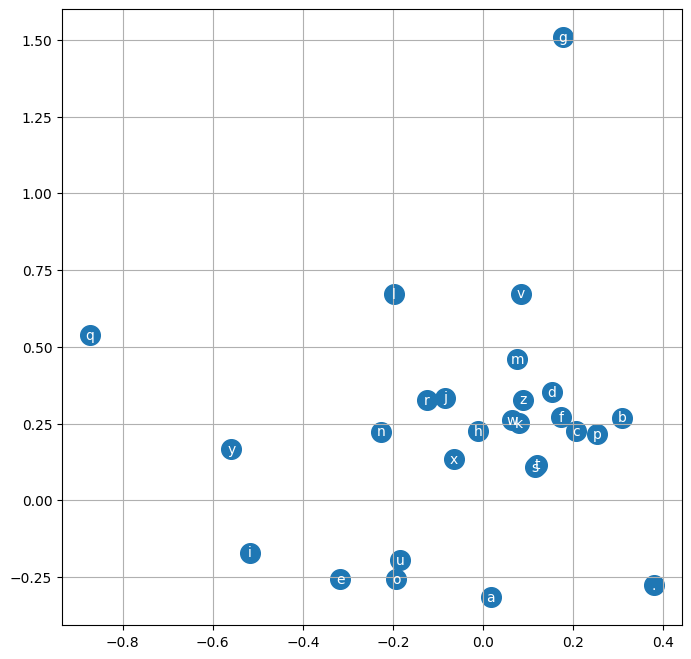

In [62]:
plt.figure(figsize=(8, 8))

# plot the embeddings -- col 0 is x axis, col 1 is y axis
plt.scatter(C[:, 0].data, C[:, 1].data, s=200) 

# annotate the points with the characters
for i in range(C.shape[0]): 
    plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha="center", va="center", color="white")
plt.grid("minor")
plt.show()

---
## 11) Final touches

---

Let's go ahead and create some variable so that we don't have to hard-code everything.

In [63]:
import random 
random.seed(42)
random.shuffle(words)

In [64]:
vocab_size = len(stoi)             # number of unique characters
block_size = 3                     # number of characters in the context
emb_size = 10                      # size of the embedding vectors
input_size = block_size * emb_size # number of neurons in the input layer (num of char embeddings * size of each embedding)
hidden_size = 200                  # number of neurons in the hidden layer

In [65]:
def build_dataset(words, block_size):
    X, Y = [], [   ]# X is nn input, Y is target label
    
    # for each word, start with the 0 index, which maps to the special token to indicate the start
    for w in words:
        context = [0] * block_size
        for ch in w + ".":      # iterate over chars in words with the special token appended to the end
            ix = stoi[ch]       # get the index of the current character
            X.append(context)   # add the context, the input to the network
            Y.append(ix)        # add the true output given the context
            # print("".join(itos[i] for i in context), "--->", itos[ix])
            context = context[1:] + [ix] # move the context window over by one
    X = torch.tensor(X) 
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

In [66]:
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))
print(n1, n2)

25626 28829


In [67]:
Xtr, Ytr = build_dataset(words[:n1], block_size)
Xdev, Ydev = build_dataset(words[n1:n2], block_size)
Xte, Yte = build_dataset(words[n2:], block_size)

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [68]:
g = torch.Generator().manual_seed(2147483647)  
C = torch.randn((vocab_size, emb_size), generator=g)        # embedding matrix
W1 = torch.randn((input_size, hidden_size), generator=g)    # hidden layer weights
b1 = torch.randn(hidden_size, generator=g)                  # hidden layer bias
W2 = torch.randn((hidden_size, vocab_size), generator=g)    # output layer weights
b2 = torch.randn(vocab_size, generator=g)                   # output layer bias
parameters = [C, W1, b1, W2, b2]                            # collect the parameters

for p in parameters:
    p.requires_grad = True

sum(p.numel() for p in parameters)

11897

In [69]:
# keep track of the learning rate exponent and the loss at each iteration
lossi = []


batch_size = 32
num_iters = 200_000
for i in range(num_iters):
    # minibatch construct
    # select a random subset of the data using the indices in X: [0, N-1]
    ix = torch.randint(0, Xtr.shape[0], (batch_size,)) 

    # forward pass
    emb = C[Xtr[ix]] # (batch_size, block_size, emb_size)
    h = torch.tanh(emb.view(-1, input_size) @ W1 + b1) # (batch_size, hidden_size)
    logits = h @ W2 + b2 # (batch_size, 27)
    loss = F.cross_entropy(logits, Ytr[ix])

    # backward pass
    for p in parameters:   
        p.grad = None   # clear the gradients 
    loss.backward()     # populate the gradients

    # learning rate schedule
    lr = 0.1 if i < 100_000 else 0.01
    
    # parameter update
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    lossi.append(loss.log10().item())

    print(f"i: {i+1}/{num_iters}, loss: {loss.item()}", end="\r")

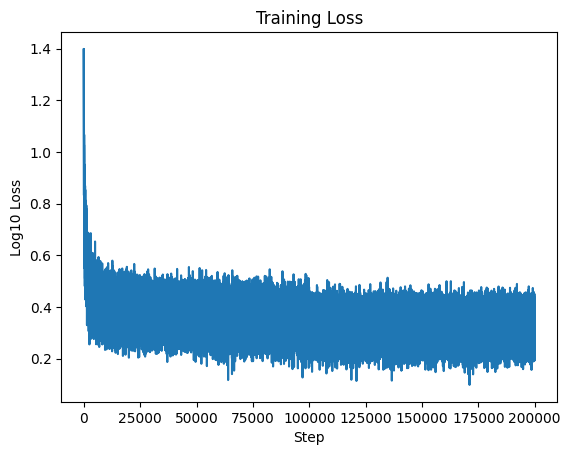

In [70]:
plt.plot(lossi)
plt.title("Training Loss")
plt.xlabel("Step")
plt.ylabel("Log10 Loss")
plt.show()

We can evaluate the loss on the entire training set

In [71]:
emb = C[Xtr] # (batch_size, block_size, emb_size)
h = torch.tanh(emb.view(-1, input_size) @ W1 + b1) # (batch_size, hidden_size)
logits = h @ W2 + b2 # (batch_size, vocab_size)
loss = F.cross_entropy(logits, Ytr)
loss.item()

2.1234943866729736

And over the validation set

In [72]:
emb = C[Xdev] # (batch_size, block_size, emb_size)
h = torch.tanh(emb.view(-1, input_size) @ W1 + b1) # (batch_size, hidden_size)
logits = h @ W2 + b2 # (batch_size, vocab_size)
loss = F.cross_entropy(logits, Ydev)
loss.item()

2.158396005630493

What can be done to improve the model further:

1) Change the number of neurons in the hidden layer
2) Change the dimensionality of the embedding / lookup table
3) Change the context size / number of characters fed in as input
4) Change the number of training iterations
5) Change how the learning rate changes with time
6) Change the batch size 

---
## 12) Sampling from the model

---

In [73]:
g = torch.Generator().manual_seed(2147483647 + 10)  

num_words = 20
for _ in range(num_words):
    out = []                       # store the generated characters
    context = [0] * block_size     # block_size of start tokens, [0, 0, 0, ...]
    while True:
        # forward pass -- embed context, then predict next char
        emb = C[torch.tensor(context)]                     # (1, block_size, emb_size) -- batch_size of 1
        h = torch.tanh(emb.view(-1, input_size) @ W1 + b1) # (1, hidden_size)
        logits = h @ W2 + b2

        # sample the next character from the output distribution
        probs = F.softmax(logits, dim=1)
        pred = torch.multinomial(probs, num_samples=1, generator=g).item() 

        # shift the context window by one
        context = context[1:] + [pred]
        
        # store prediction and end if we reach special token
        out.append(pred)
        if pred == 0: 
            break
    print("".join(itos[i] for i in out)) # print current generated word

carmah.
ambrilli.
kimri.
rehty.
halaysa.
jazhnen.
delynn.
jareli.
nellara.
chaiiy.
kaleigh.
ham.
pory.
quint.
sulin.
alianni.
watell.
dearyni.
jaxen.
ivrat.
